<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/insurance_myV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Step 1: Load the dataset
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify file path
file_path = '/content/drive/My Drive/telematics_syn.csv'

# Import pandas (assuming you want to use it to read the CSV)
import pandas as pd

# Read the CSV file
data = pd.read_csv(file_path)

# Step 2: Explore the data
print(data.head())
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Display basic statistics
print(data.describe())

Mounted at /content/drive
   Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   

   Left.turn.intensity11  Left

The reason you see "8 rows x 48 columns" in the last line of the output instead of 52 columns is because the `describe()` method in pandas only returns summary statistics for **numeric** columns by default.

In your dataset, you likely have 4 non-numeric columns (such as categorical or string data). Specifically, these columns could be:

- `Insured.sex` (object type)
- `Marital` (object type)
- `Car.use` (object type)
- `Region` (object type)

These non-numeric columns are excluded from the `describe()` summary, which is why the result only includes the 48 numeric columns.

To see a summary of non-numeric columns, you can pass the argument `include='all'` to the `describe()` function:

```python
data.describe(include='all')
```

This will include statistics for both numeric and non-numeric columns, such as the count, unique values, top value, and frequency for categorical columns.

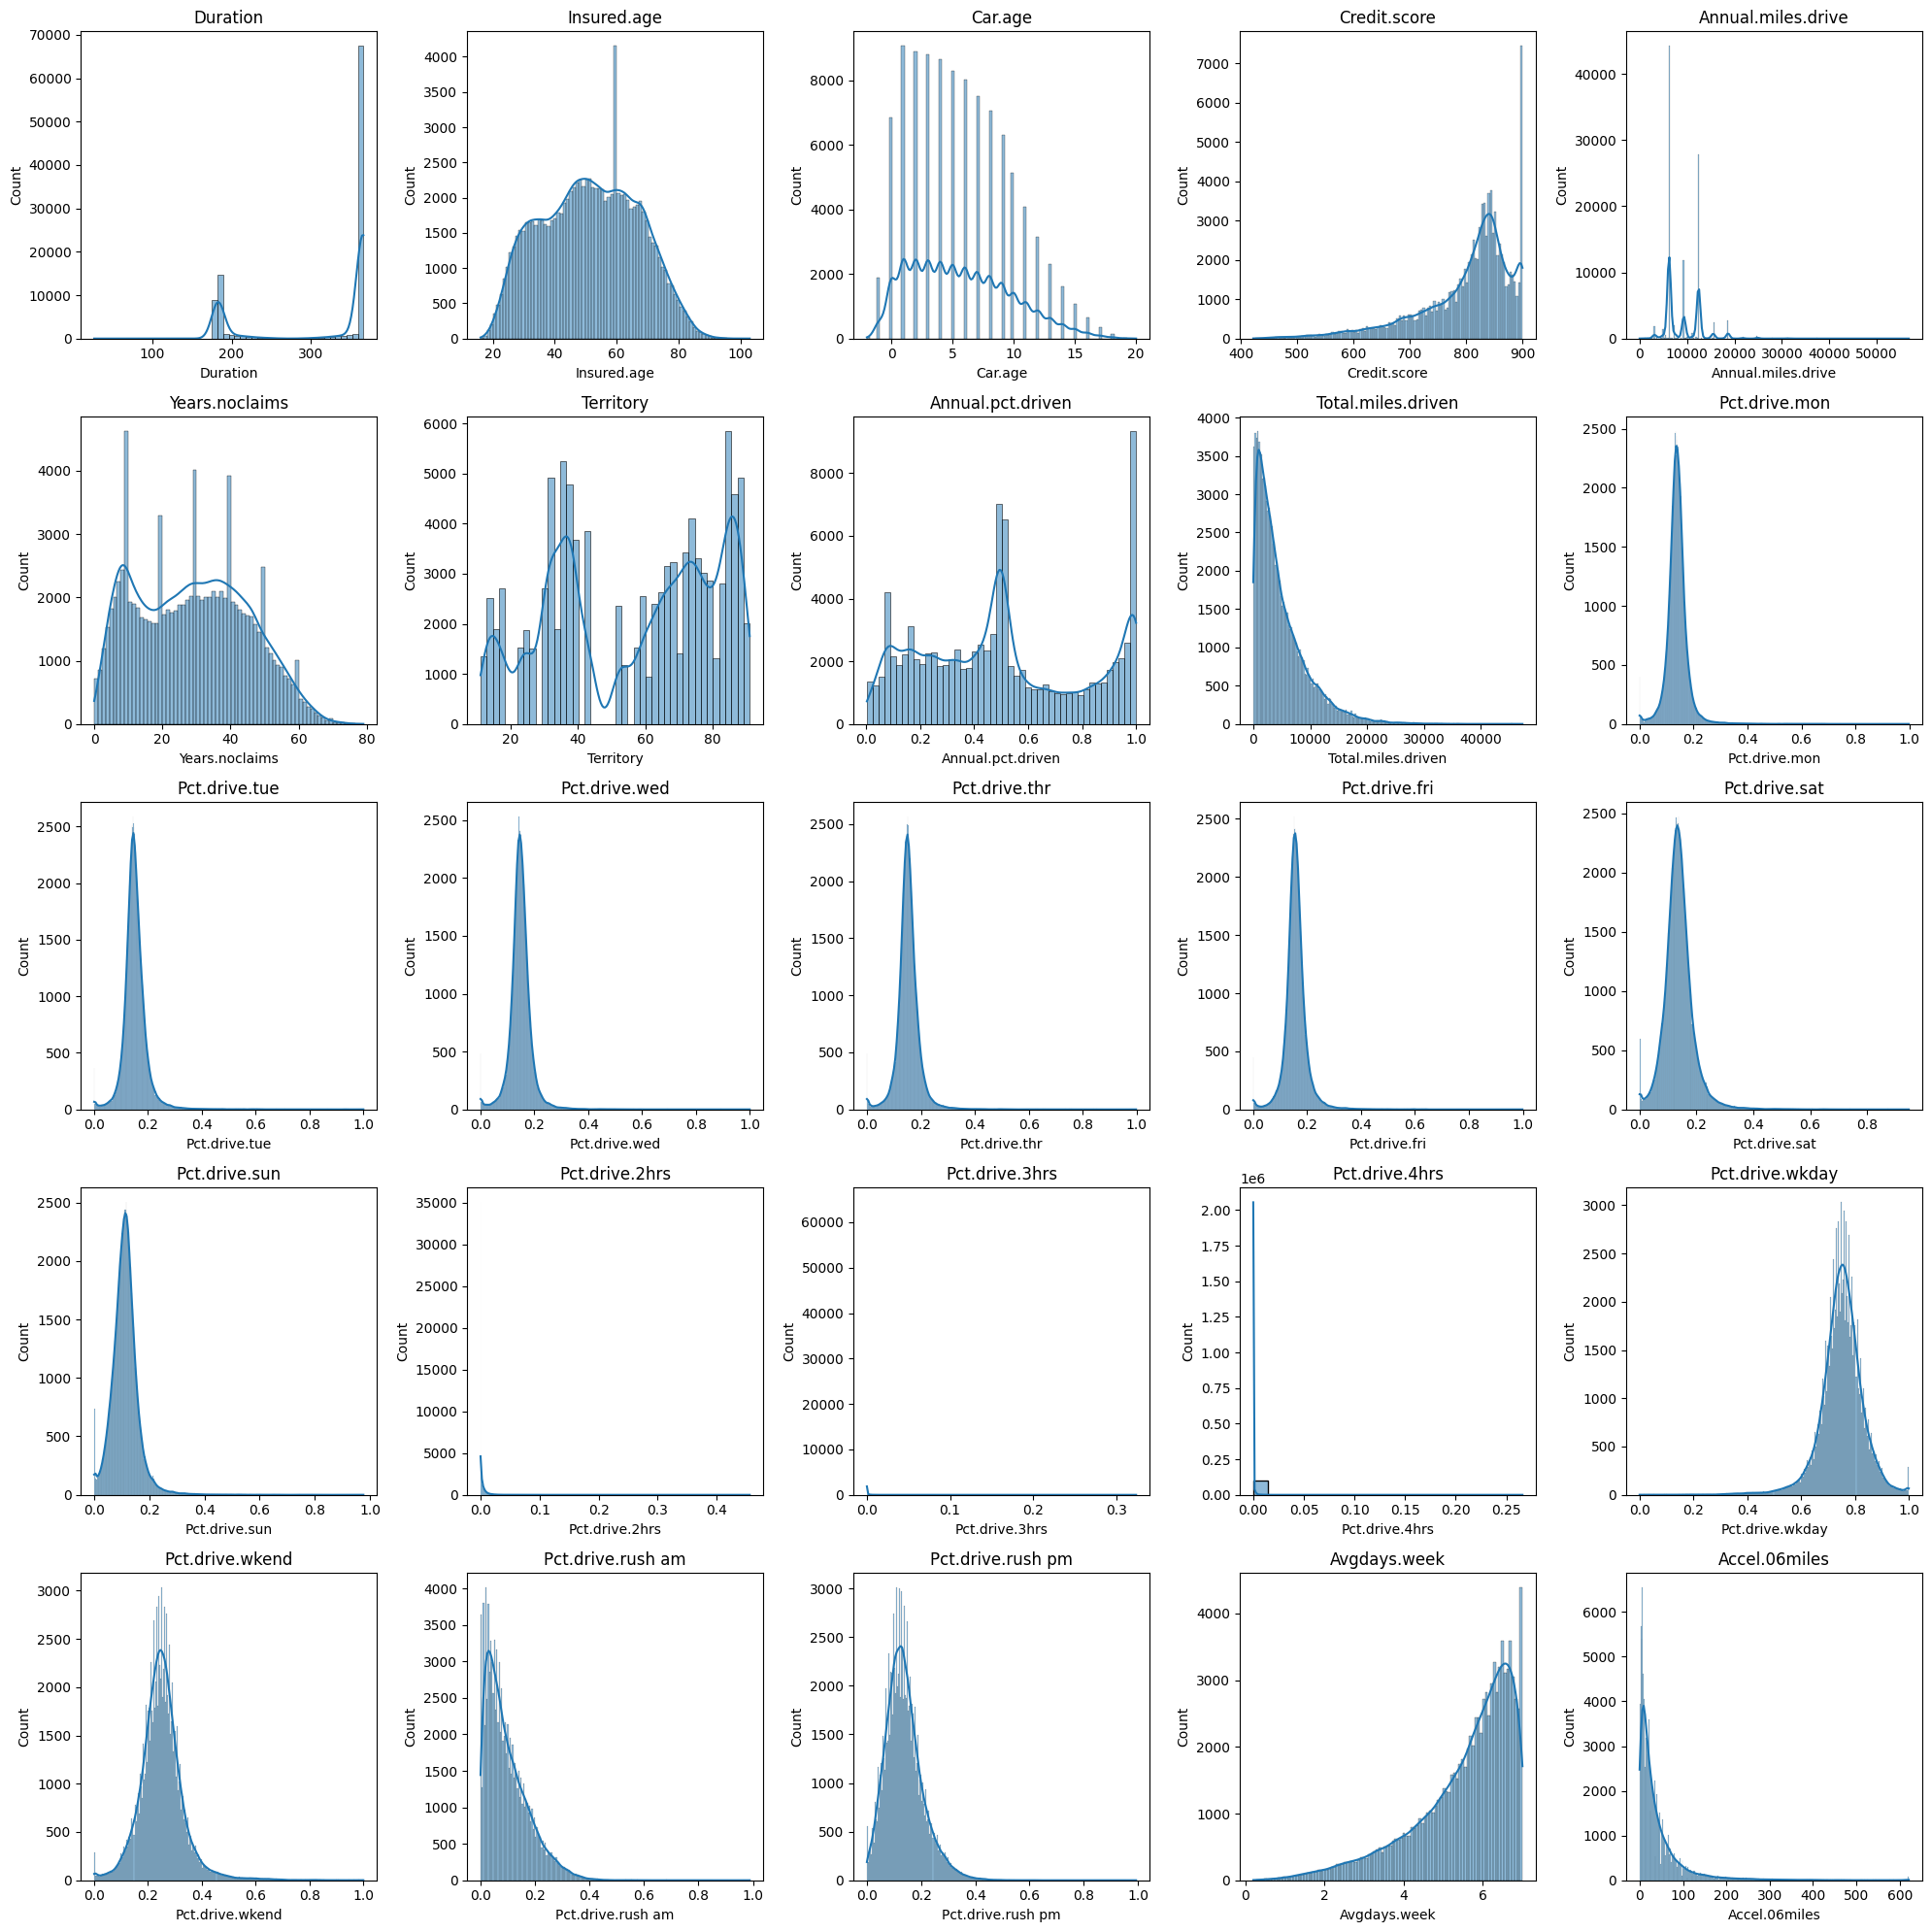

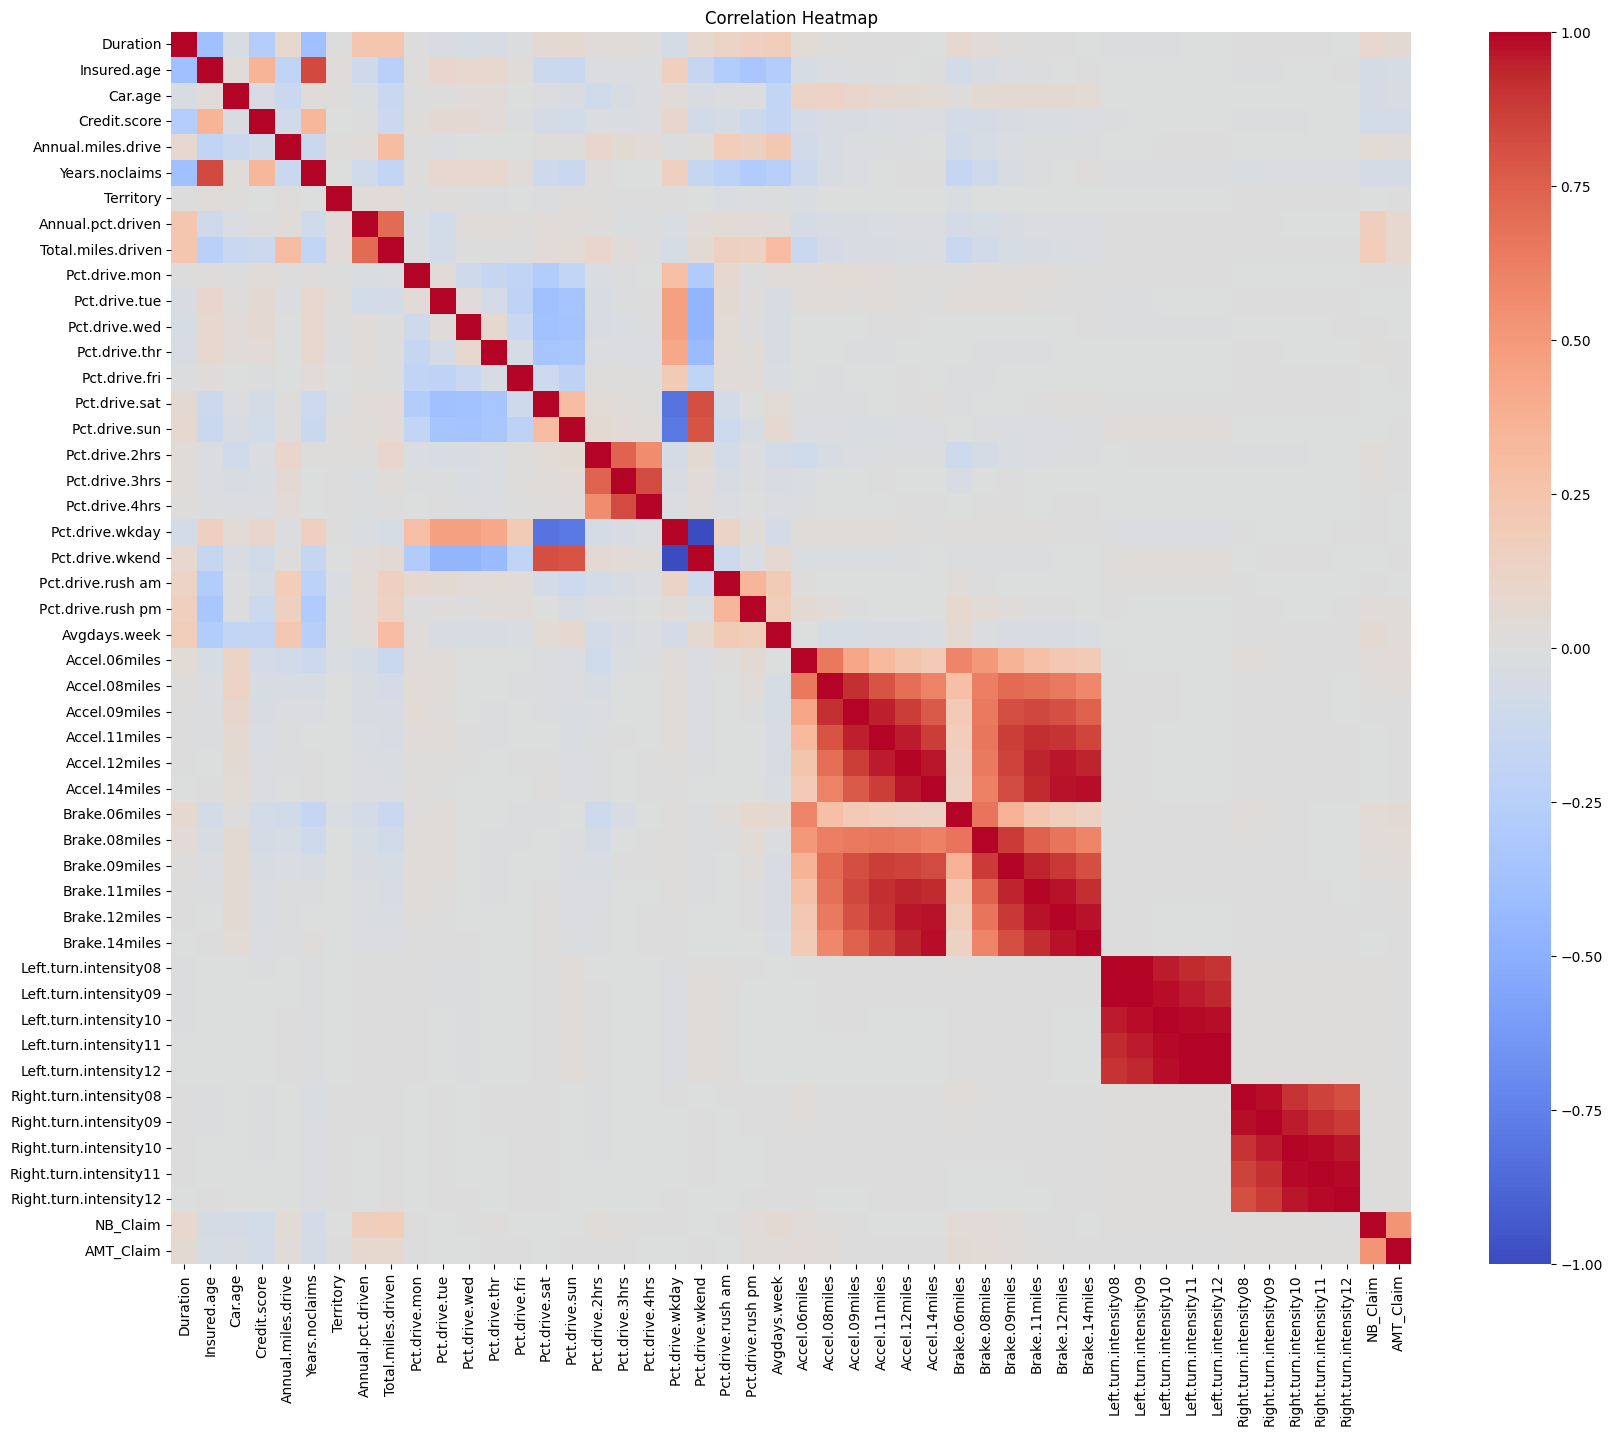

In [4]:
# Step 3: Visualize the data

# Histogram of numeric columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.ravel()

for i, col in enumerate(numeric_columns[:25]):  # Limit to 25 columns for readability
    sns.histplot(data[col], ax=axs[i], kde=True)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

# Correlation heatmap
corr_matrix = data[numeric_columns].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [8]:
# Step 4: Feature engineering
# Create a new feature: total turns (summing available turn intensity columns)
data['total_turns'] = (data['Left.turn.intensity08'] + data['Left.turn.intensity09'] +
                       data['Left.turn.intensity10'] + data['Left.turn.intensity11'] +
                       data['Left.turn.intensity12'] +
                       data['Right.turn.intensity08'] + data['Right.turn.intensity09'] +
                       data['Right.turn.intensity10'] + data['Right.turn.intensity11'] +
                       data['Right.turn.intensity12'])

# Create a new feature: turn ratio (you can adjust this based on your assumptions)
data['turn_ratio'] = (data['Left.turn.intensity08'] + data['Left.turn.intensity09'] +
                      data['Left.turn.intensity10'] + data['Left.turn.intensity11'] +
                      data['Left.turn.intensity12']) / (data['Right.turn.intensity08'] +
                                                       data['Right.turn.intensity09'] +
                                                       data['Right.turn.intensity10'] +
                                                       data['Right.turn.intensity11'] +
                                                       data['Right.turn.intensity12'] + 1)  # Avoid division by zero

# Approximate harsh acceleration count by summing acceleration columns
data['harsh_accel_count'] = (data['Accel.06miles'] + data['Accel.08miles'] +
                             data['Accel.09miles'] + data['Accel.11miles'] +
                             data['Accel.12miles'] + data['Accel.14miles'])

# Approximate harsh braking count by summing braking columns
data['harsh_brake_count'] = (data['Brake.06miles'] + data['Brake.08miles'] +
                             data['Brake.09miles'] + data['Brake.11miles'] +
                             data['Brake.12miles'] + data['Brake.14miles'])

# Create a new feature: risk score
data['risk_score'] = (data['Insured.age'] * -0.01 +
                      data['Car.age'] * 0.02 +
                      data['Annual.miles.drive'] * 0.001 +
                      data['harsh_accel_count'] * 0.1 +
                      data['harsh_brake_count'] * 0.1 +
                      data['total_turns'] * 0.01)


In [10]:
# Step 5: Prepare data for modeling
# Select features and target
features = ['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive',
            'harsh_accel_count', 'harsh_brake_count', 'total_turns', 'turn_ratio', 'risk_score']
target = 'NB_Claim'

# Define features (X) and target (y)
X = data[features]
y = data[target]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for class imbalance in the training set
print("Class distribution before SMOTE:")
print(Counter(y_train))

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print(Counter(y_train_smote))

# The data is now ready for model training and evaluation


Class distribution before SMOTE:
Counter({0: 76598, 1: 3240, 2: 153, 3: 9})
Class distribution after SMOTE:
Counter({0: 76598, 1: 76598, 3: 76598, 2: 76598})


In [11]:
# Step 6: Custom Insurance Prediction Model

class CustomInsuranceModel:
    def __init__(self, thresholds=None, weights=None):
        """
        Initialize the custom insurance model with optional thresholds and weights.
        thresholds: dict - custom thresholds for features to make decisions.
        weights: dict - feature weights for scoring (if using a weighted aggregation method).
        """
        # Default thresholds (you can tweak these based on domain knowledge)
        self.thresholds = thresholds if thresholds else {
            'Credit.score': 600,  # Example threshold for credit score
            'Insured.age': 50,    # Example age threshold
            'Annual.miles.drive': 15000,  # Example for high mileage
            'risk_score': 0.5     # Example threshold for custom risk score
        }
        # Default weights for a custom weighted scoring approach
        self.weights = weights if weights else {
            'Credit.score': -0.1,      # Lower credit score increases risk
            'Insured.age': -0.05,      # Older age slightly increases risk
            'Annual.miles.drive': 0.01, # Higher mileage increases risk
            'harsh_accel_count': 0.05,  # Frequent harsh acceleration increases risk
            'harsh_brake_count': 0.05,  # Frequent harsh braking increases risk
            'total_turns': 0.02,       # More turns can indicate risky driving
            'risk_score': 0.5          # Risk score based on custom features
        }

    def predict(self, X):
        """
        Predict risk (high or low) for each row in the dataset X.
        :param X: DataFrame - the dataset containing feature values.
        :return: list of predictions (0 for low risk, 1 for high risk).
        """
        predictions = []
        for index, row in X.iterrows():
            # Rule-based prediction based on thresholds
            if (row['Credit.score'] < self.thresholds['Credit.score'] or
                row['Insured.age'] > self.thresholds['Insured.age'] or
                row['Annual.miles.drive'] > self.thresholds['Annual.miles.drive'] or
                row['risk_score'] > self.thresholds['risk_score']):
                predictions.append(1)  # High risk
            else:
                predictions.append(0)  # Low risk
        return predictions

    def predict_with_weights(self, X):
        """
        Predict using a custom weighted scoring method.
        :param X: DataFrame - the dataset containing feature values.
        :return: list of predictions (0 for low risk, 1 for high risk).
        """
        predictions = []
        for index, row in X.iterrows():
            # Calculate a weighted score using the feature weights
            score = (row['Credit.score'] * self.weights['Credit.score'] +
                     row['Insured.age'] * self.weights['Insured.age'] +
                     row['Annual.miles.drive'] * self.weights['Annual.miles.drive'] +
                     row['harsh_accel_count'] * self.weights['harsh_accel_count'] +
                     row['harsh_brake_count'] * self.weights['harsh_brake_count'] +
                     row['total_turns'] * self.weights['total_turns'] +
                     row['risk_score'] * self.weights['risk_score'])

            # Determine prediction based on the weighted score
            if score > 0.5:  # Example threshold (can be adjusted)
                predictions.append(1)  # High risk
            else:
                predictions.append(0)  # Low risk
        return predictions

# Instantiate the model
custom_model = CustomInsuranceModel()

# Predict using the rule-based method
y_pred_rules = custom_model.predict(X_test)

# Predict using the custom weighted method
y_pred_weighted = custom_model.predict_with_weights(X_test)

# Evaluate the performance of the model
from sklearn.metrics import classification_report

# Rule-based method evaluation
print("Rule-based model performance:")
print(classification_report(y_test, y_pred_rules))

# Weighted method evaluation
print("Weighted method performance:")
print(classification_report(y_test, y_pred_weighted))


Rule-based model performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19130
           1       0.04      1.00      0.08       821
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00         2

    accuracy                           0.04     20000
   macro avg       0.01      0.25      0.02     20000
weighted avg       0.00      0.04      0.00     20000

Weighted method performance:
              precision    recall  f1-score   support

           0       0.98      0.22      0.36     19130
           1       0.05      0.89      0.09       821
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00         2

    accuracy                           0.25     20000
   macro avg       0.26      0.28      0.11     20000
weighted avg       0.94      0.25      0.35     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m